# A guided tour of the raw HLC images and calibration files

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.io.fits as fits
%matplotlib inline

In [2]:
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.cmap'] = 'inferno'
#plt.style.use('dark_background')

## Set paths to data and calibration files 

In [3]:
%ls ../../Data

HLC/          SS/           planet_b.csv  rv.dat


In [4]:
%ls ../../Data/HLC/

HLC CAL/  HLC DATA/ HLC proc/


In [5]:
data_dir = os.path.relpath('../../Data/HLC/HLC DATA/')
cal_dir = os.path.relpath('../../Data/HLC/HLC CAL/')

In [6]:
os.listdir(data_dir)

['HLC_refstar_coadd_epoch04.fits',
 '.DS_Store',
 'HLC_refstar_coadd_epoch02.fits',
 'HLC_scistar_coadd_epoch01.fits',
 'HLC_refstar_coadd_epoch03.fits',
 'HLC_scistar_coadd_epoch02.fits',
 'HLC_scistar_coadd_epoch03.fits',
 'HLC_refstar_coadd_epoch01.fits',
 'HLC_scistar_coadd_epoch04.fits']

In [7]:
os.listdir(cal_dir)

['OS6_HLC_PSFs_offset.fits',
 'OS6_HLC_PSFs_fine_offset_list.fits',
 'unocc_star_psf.png',
 'OS6_HLC_PSFs_fine_offset.fits',
 'OS6_HLC_PSF_peak_map.fits',
 'HLC_scistar_unocc_PSF_model.fits',
 'OS6_HLC_PSFs_offset_list.fits',
 'hlc_psf_peak_map.png']

### Load data images and headers

In [8]:
scistar_coadd_ep1_data = fits.getdata(
        os.path.join(data_dir, 'HLC_scistar_coadd_epoch01.fits'))
scistar_coadd_ep2_data = fits.getdata(
        os.path.join(data_dir, 'HLC_scistar_coadd_epoch02.fits'))
scistar_coadd_ep3_data = fits.getdata(
        os.path.join(data_dir, 'HLC_scistar_coadd_epoch03.fits'))
scistar_coadd_ep4_data = fits.getdata(
        os.path.join(data_dir, 'HLC_scistar_coadd_epoch04.fits'))

refstar_coadd_ep1_data = fits.getdata(
        os.path.join(data_dir, 'HLC_refstar_coadd_epoch01.fits'))
refstar_coadd_ep2_data = fits.getdata(
        os.path.join(data_dir, 'HLC_refstar_coadd_epoch02.fits'))
refstar_coadd_ep3_data = fits.getdata(
        os.path.join(data_dir, 'HLC_refstar_coadd_epoch03.fits'))
refstar_coadd_ep4_data = fits.getdata(
        os.path.join(data_dir, 'HLC_refstar_coadd_epoch04.fits'))

scistar_coadd_ep1_hdr = fits.getheader(
        os.path.join(data_dir, 'HLC_scistar_coadd_epoch01.fits'))
refstar_coadd_ep1_hdr = fits.getheader(
        os.path.join(data_dir, 'HLC_refstar_coadd_epoch01.fits'))

The science co-add array dimensions are 2 rolls x 45 pixels x 45 pixels.

In [9]:
scistar_coadd_ep4_data.shape

(2, 45, 45)

In [10]:
imgwidth = scistar_coadd_ep4_data.shape[2]
print(imgwidth)

45


The reference co-add array is similar but has only one roll state.

In [11]:
refstar_coadd_ep1_data.shape

(45, 45)

You can load an extension to see the actual roll angles, in degrees. Our observing scenarios throughout the tutorial and the official data challenge use the same two observatory roll states: 0.0 deg and 26.0 deg. 

In [12]:
scistar_coadd_ep1_rolls = fits.getdata(
        os.path.join(data_dir, 'HLC_scistar_coadd_epoch01.fits'),
        extname='ROLLS')

scistar_coadd_ep1_rolls

array([ 0., 26.])

The FITS header has some useful information such as the pixel scale in units of both arcseconds and lambda/D, the bandpass wavelengths, and some catalog data for the target star. 

In [13]:
scistar_coadd_ep1_hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   45                                                  
NAXIS2  =                   45                                                  
NAXIS3  =                    2                                                  
EXTEND  =                    T                                                  
UNITS   = 'photoelectrons'                                                      
INTTIME =              52800.0 / seconds per roll per epoch                     
PIX_AS  =            0.0210804 / arcsec                                         
PIX_LD  =   0.4200002390847835 / lam/D                                          
LAMBDA  =                575.0 / nm                                             
MINLAM  =               546.

## Plot the science target co-adds from the second epoch

- The co-added images represent the total photoelectrons from the CCD array over the course of an integration sequence (in this case 52800 seconds). The pixel values are integers.

- The star has been centered on the middle pixel of the array (column 22, row 22 for indices counting from zero), so there is no need to register the star's position.

- Assume that flat field errors, detector bias and dark current have also been corrected.

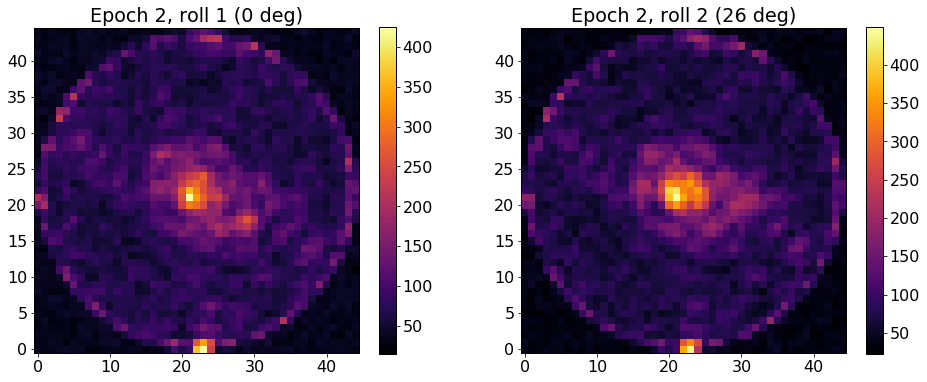

In [14]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(scistar_coadd_ep2_data[0])
plt.title('Epoch 2, roll 1 (0 deg)')
plt.colorbar()

plt.subplot(122)
plt.title('Epoch 2, roll 2 (26 deg)')
plt.imshow(scistar_coadd_ep2_data[1])
plt.colorbar()

## Roll subtraction and roll combination 

Taking the direct differences between the co-adds acquired in opposite roll states reveals a preliminary point source detection, and confirms the relative orientation of the roll.

Relative to roll 1, the sky in roll 2 appears rotated 26 degrees counter-clockwise.

In [15]:
diff_1 = scistar_coadd_ep1_data[0] - scistar_coadd_ep1_data[1]
diff_2 = scistar_coadd_ep1_data[1] - scistar_coadd_ep1_data[0] 

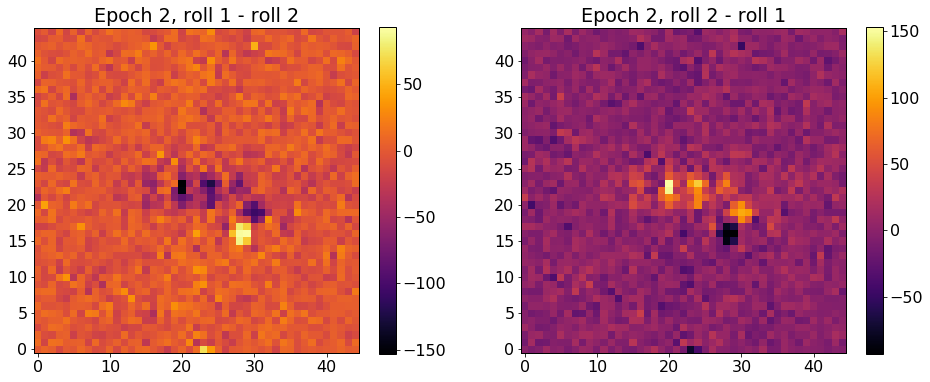

In [16]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(diff_1)
plt.title('Epoch 2, roll 1 - roll 2')
plt.colorbar()

plt.subplot(122)
plt.title('Epoch 2, roll 2 - roll 1')
plt.imshow(diff_2)
plt.colorbar()

### De-rotate the second difference and sum with the first difference

In [17]:
import skimage.transform
derot_diff_2 = skimage.transform.rotate(image = diff_2.astype(np.float),
                                        angle = scistar_coadd_ep1_rolls[1],
                                        center = (imgwidth // 2, imgwidth // 2),
                                        order = 3, cval = np.nan)
derot_sum = diff_1 + derot_diff_2

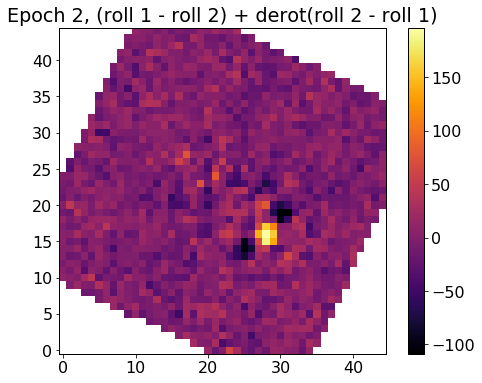

In [18]:
plt.figure(figsize=(8,6))

plt.imshow(derot_sum)

plt.title('Epoch 2, (roll 1 - roll 2) + derot(roll 2 - roll 1)')
plt.colorbar()

## Group question 1. How would you estimate the signal-to-noise ratio of this source? 

## Reference differential imaging

Plot the science star from epoch 3 alongside the reference image from the same epoch.

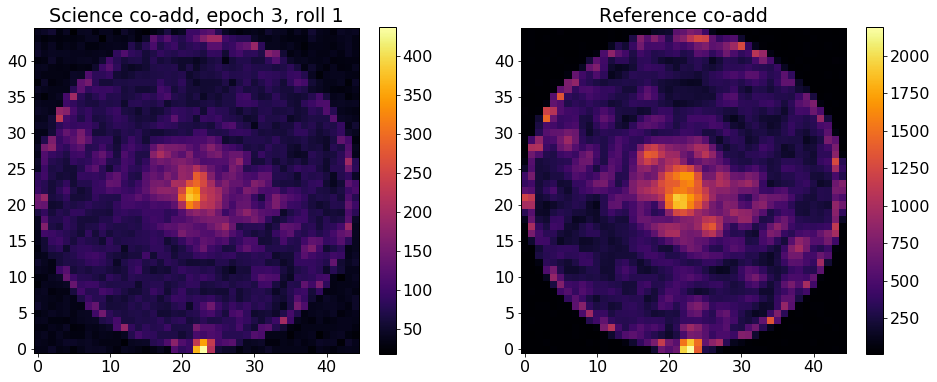

In [19]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(scistar_coadd_ep3_data[0])
plt.title('Science co-add, epoch 3, roll 1')
plt.colorbar()

plt.subplot(122)
plt.title('Reference co-add')
plt.imshow(refstar_coadd_ep3_data)
plt.colorbar()

### Compute reference-to-science count ratio (crude but good enough for a first-pass inspection)

In [20]:
count_sum_ratio = (np.sum(refstar_coadd_ep3_data)
                    / np.sum(scistar_coadd_ep3_data[0]))
print(count_sum_ratio)

4.63906059159418


In [21]:
crude_rdi_result = (scistar_coadd_ep3_data[0]
                    - refstar_coadd_ep3_data / count_sum_ratio)

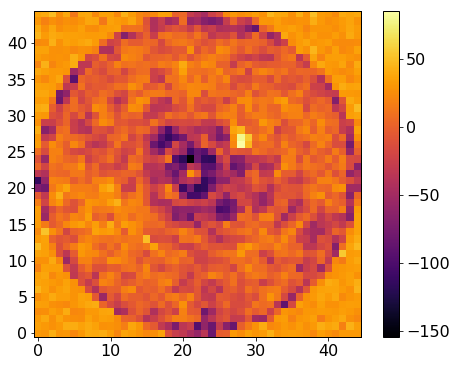

In [22]:
plt.figure(figsize=(8,6))

plt.imshow(crude_rdi_result)

plt.colorbar()

## Group question 2: what things could we do to improve this subtraction?

## Calibration files

In [23]:
os.listdir(cal_dir)

['OS6_HLC_PSFs_offset.fits',
 'OS6_HLC_PSFs_fine_offset_list.fits',
 'unocc_star_psf.png',
 'OS6_HLC_PSFs_fine_offset.fits',
 'OS6_HLC_PSF_peak_map.fits',
 'HLC_scistar_unocc_PSF_model.fits',
 'OS6_HLC_PSFs_offset_list.fits',
 'hlc_psf_peak_map.png']

### 1. Unocculted star PSF

To enable conversion between the detector counts and flux ratio units, we provide a model of the science target star's PSF, as if it were *not* occulted by the coronagraph. The PSF is centered on the image array (column=22, row=22) and represented in units of photons / second at the detector. The effective QE of the EMCCD (roughly 0.75) has not been applied to this model.

In [24]:
scistar_unocc_psf = fits.getdata(os.path.join(cal_dir, 'HLC_scistar_unocc_PSF_model.fits'))

The photon arrival rate in the peak pixel is 1.096E+06 photons / sec


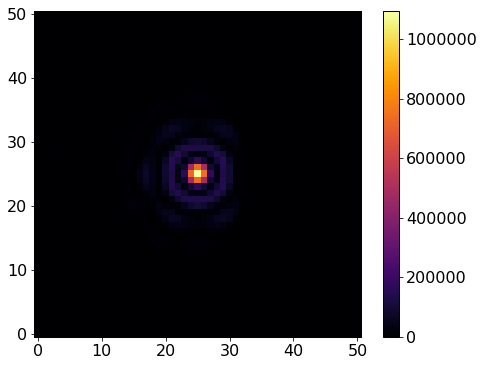

In [25]:
plt.figure(figsize=(8,6))
plt.imshow(scistar_unocc_psf)
plt.colorbar()
print('The photon arrival rate in the peak pixel is {:.4G} photons / sec'.format(np.max(scistar_unocc_psf)))

### 2. Hi-res off-axis PSF model

There are two FITS cubes containing off-axis PSF models:
- 'OS6_HLC_PSFs_offset.fits'
- 'OS6_HLC_PSFs_fine_offset.fits'

Each cube represents the PSF of a point source seen by the HLC at different separations from the occulting mask. They are sampled at $0.1~\lambda_c/D$, where $\lambda_c$ is the central wavelength of the bandpass (575 nm) and $D$ is the 2.37-meter telescope aperture. This sampling is intentionally finer than the detector pixel sampling (about $0.42~\lambda_c/D$), to enable shifting the PSF model to arbitrary positions with minimal interpolation noise.

In [26]:
psfs_offset = fits.getdata(os.path.join(cal_dir, 'OS6_HLC_PSFs_offset.fits'))
psfs_fine_offset = fits.getdata(os.path.join(cal_dir, 'OS6_HLC_PSFs_fine_offset.fits'))

print('Dimensions of OS6_HLC_PSFs_offset.fits: {:}'.format(psfs_offset.shape))
print('Dimensions of OS6_HLC_PSFs_fine_offset.fits: {:}'.format(psfs_fine_offset.shape))

Dimensions of OS6_HLC_PSFs_offset.fits: (17, 200, 200)
Dimensions of OS6_HLC_PSFs_fine_offset.fits: (26, 200, 200)


The source separations corresponding to each of the PSF cubes are stored in separate FITS arrays:

- 'OS6_HLC_PSFs_offset_list.fits'
- 'OS6_HLC_PSFs_fine_offset_list.fits'

The offsets are in these arrays are specified in units of $\lambda_c/D$. Note the outer working angle (maximum separation of high-contrast observations) of this HLC design is $9.0~\lambda_c/D$. The inner working angle, where the coronagraph transmission vanishes, occurs around $2.2~\lambda_c/D$.

In [27]:
offset_list = fits.getdata(os.path.join(cal_dir, 'OS6_HLC_PSFs_offset_list.fits'))
fine_offset_list = fits.getdata(os.path.join(cal_dir, 'OS6_HLC_PSFs_fine_offset_list.fits'))

print(offset_list)
print(fine_offset_list)

[0.89999998 2.0999999  2.4000001  2.70000005 3.29999995 3.5999999
 3.9000001  4.5        4.80000019 5.4000001  6.         7.19999981
 8.10000038 8.39999962 8.69999981 9.         9.30000019]
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5]


Plot an example PSF

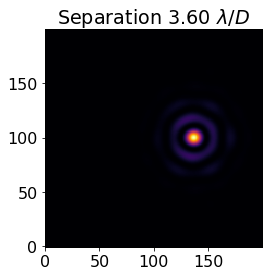

In [28]:
sep_ind = 5
plt.figure(figsize=(4,4))
plt.title('Separation {:.2f} $\lambda/D$'.format(offset_list[sep_ind]))
plt.imshow(psfs_offset[sep_ind,:,:])

### 3. PSF peak map

This is the PSF transmission map of the HLC. Each element in the array is the peak of a PSF centered at that location. This is represented at the same high spatial sampling ($0.1~\lambda_c/D$) as the off-axis PSF model arrays.

Similar to the off-axis PSF model, the flux in each spatial sample is normalized to the incident energy in the illuminated region of the primary mirror. It does **not** include mirror reflectivity and filter transmission losses, only the mathematical throughput of the coronagraph.

The structure of the depression at the center is determined by the optical profile of the HLC's occulting mask.

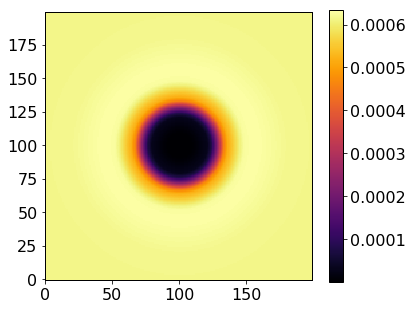

In [29]:
psf_peak_map = fits.getdata(os.path.join(cal_dir, 'OS6_HLC_PSF_peak_map.fits'))

plt.figure(figsize=(6,5))
plt.imshow(psf_peak_map)
plt.colorbar()

Cross section

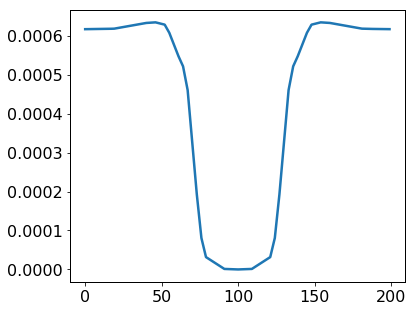

In [30]:
plt.figure(figsize=(6,5))
plt.plot(psf_peak_map[psf_peak_map.shape[0] // 2, :])

### Example: Compare the PSF at separations $2.2~\lambda_c/D$ and $6.0~\lambda_c/D$

Notes:
    
- The model PSFs are provided only at positive horizontal offsets. Different source position angles can be approximated by rotating the model about the center. Different separations can be approximated by shifting the array from its closest spatial sample.


- At close separations, the PSF is distorted and the flux is suppressed by the HLC's occulting mask. Notice that in this example, the peak of the $6.0~\lambda/D$ PSF is $\sim8\,\times$ brigther than the $2.2~\lambda/D$ PSF.


- The PSF distortions close the inner working angle can impact your astrometry of a planet. At close separations, the apparent centroid of the PSF is biased **away** from the mask.

7.7797626476921025


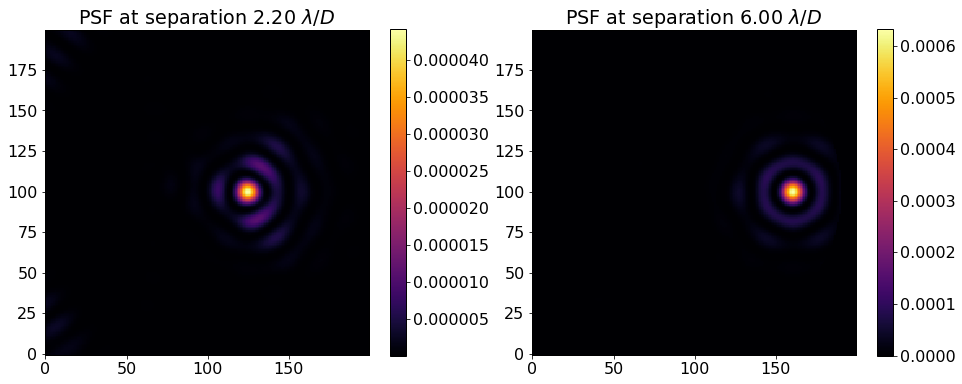

In [31]:
sep_1 = 2.2 # lambda/D
sep_2 = 6.0 # lambda/D
sep_ind_1 = np.argmin(np.abs(sep_1 - fine_offset_list))
sep_ind_2 = np.argmin(np.abs(sep_2 - offset_list))

plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title('PSF at separation {:.2f} $\lambda/D$'.format(sep_1))
plt.imshow(psfs_fine_offset[sep_ind_1])
plt.colorbar()

plt.subplot(122)
plt.title('PSF at separation {:.2f} $\lambda/D$'.format(sep_2))
plt.imshow(psfs_offset[sep_ind_2])
plt.colorbar()

print((np.max(psfs_fine_offset[sep_ind_2])
       / np.max(psfs_fine_offset[sep_ind_1])))

## Group question 3: How could you calibrate the bias in the centroid due to the distortion of the occulting mask?

### What is the normalized energy in the PSF, integrated over the image?

In [32]:
np.sum(psfs_fine_offset[sep_ind_2])

0.12137494932239253

## Group question 4: how would you measure the throughput of the coronagraph to only the core of the PSF?